# Mouse neurosphere Plp1+ cells (GFP+)

### paper: https://doi.org/10.1016/j.celrep.2023.112194

### Figure 1d

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Get the original magma colormap
magma = plt.cm.get_cmap('magma', 256)

# Convert to array and prepend grey
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])  # RGBA for light grey

# Combine: grey for near-zero, then rest of magma
new_colors = np.vstack((grey, magma_colors[20:]))  # skip darkest part of magma
custom_cmap1 = ListedColormap(new_colors)

In [3]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" 
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [30]:
#loading data
adata = sc.read_csv("GSE184981_3d_scrna_counts.csv.gz").T

In [31]:
# Mark mitochondrial and ribosomal genes
adata.var['mt'] = adata.var_names.str.startswith("mt-")
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [32]:
#adding a column in adata.obs to show mouse id
adata.obs['mouse_id'] = np.zeros(len(adata.obs.index))

for i in adata.obs.index.values: 
    adata.obs.loc[i, 'mouse_id'] = i.split('_')[1]

counts = adata.obs['mouse_id'].value_counts()
valid_batches = counts[counts >= 2].index
adata = adata[adata.obs['mouse_id'].isin(valid_batches)].copy()

In [33]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt', 'ribo'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [34]:
# Filter cells by st. dev 
genes_std = np.std(np.array(adata.obs['n_genes_by_counts']))
genes_mean = np.mean(np.array(adata.obs['n_genes_by_counts']))
adata = adata[(adata.obs['n_genes_by_counts'] > genes_mean - genes_std) & (adata.obs['n_genes_by_counts'] < genes_mean + genes_std)]

In [35]:
# Mitochondrial filtering (MAD-based)
adata = adata[adata.obs['pct_counts_mt'] < 10]

In [36]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [37]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', batch_key='mouse_id', n_top_genes=2500)

In [38]:
# Store raw data and subset to HVGs
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable].copy()

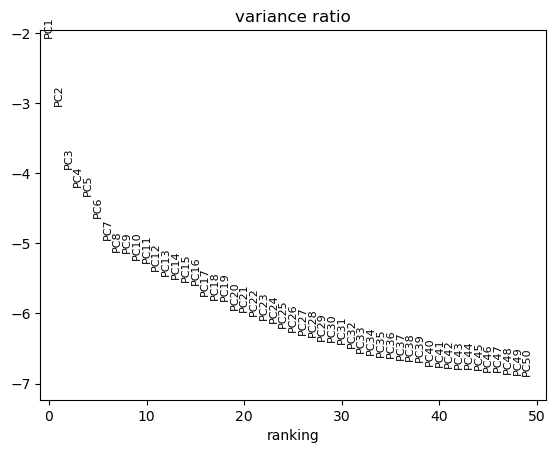

In [39]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [41]:
sc.external.pp.harmony_integrate(adata, key='mouse_id') #batch correction
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata)

2025-06-01 22:53:56,857 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
  File "C:\Users\dowpa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
2025-06-01 22:53:58,601 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-01 22:53:58,705 - harmonypy - INFO - Iteration 1 of 10
2025-06-01 22:54:01,402 - harmonypy - INFO - Iteration 2 of 

In [59]:
sc.tl.leiden(adata, resolution = 0.4)

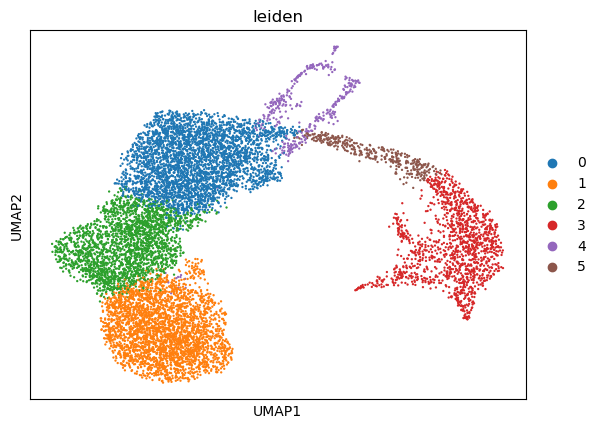

In [60]:
sc.pl.umap(adata, color=['leiden'], use_raw=True)

In [66]:
leiden_to_celltype = {
    '0': 'Glia 3',
    '1': 'Glia 1',
    '2': 'Glia 2',
    '3': 'Neuron',
    '4': 'Replicating',
    '5': 'Neuroblast',}

In [67]:
adata.obs['cell_type'] = adata.obs['leiden'].map(leiden_to_celltype)

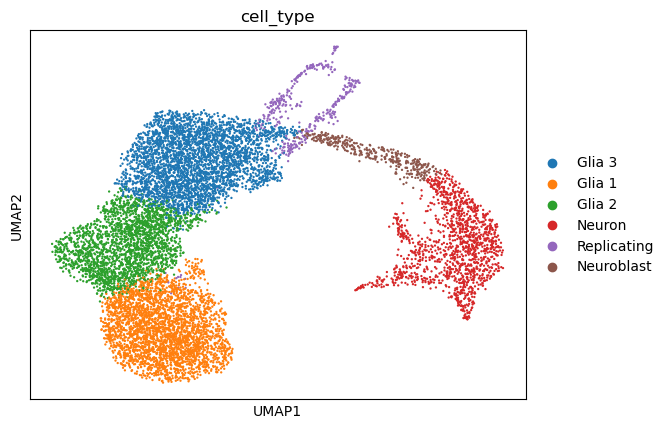

In [69]:
sc.pl.umap(adata, color=['cell_type'], use_raw=True, save='all_cells.png')

In [53]:
marker_genes = np.array([
    'Plp1', 'Itga2', 'S100b', 'Erbb3', 'Tgfb2', 'Pdgfa', 'Sox10', 'Sox2',
    'Foxd3', 'Mki67', 'Pcna', 'Hells', 'Cenpf', 'Sox11', 'Ascl1', 'Hes6',
    'Phox2b', 'Actl6b', 'Tubb3', 'Elavl4', 'Gap43', 'Stmn4', 'Bnc2', 'Etv1'
])

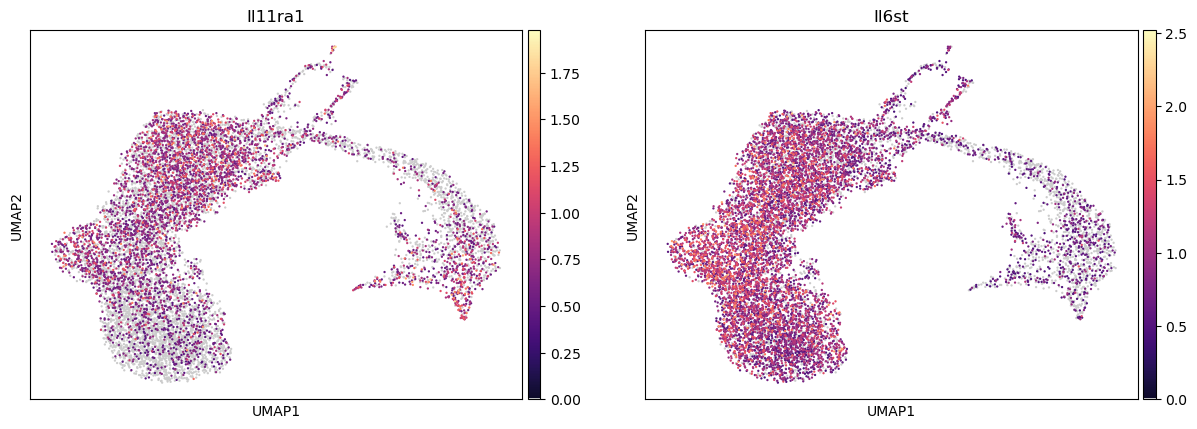

In [70]:
sc.pl.umap(adata, color=['Il11ra1', 'Il6st'], cmap=custom_cmap1, save='Il11ra1_Il6st.png')

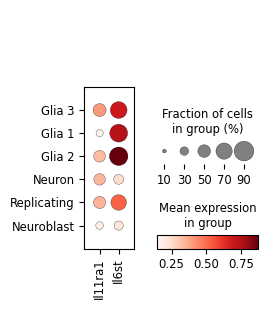

In [79]:
sc.pl.dotplot(adata, ['Il11ra1', 'Il6st'], 'cell_type', use_raw=True, save='Il11ra1_Il6st.png')

In [72]:
mouse_cytokine_receptors = np.array([
    # Interleukin receptors
    "Il1r1", "Il1r2", "Il2ra", "Il2rb", "Il2rg", "Il3ra", "Il4ra", "Il5ra", "Il6ra", "Il6st",
    "Il7r", "Il9r", "Il10ra", "Il10rb", "Il11ra1", "Il12rb1", "Il12rb2", "Il13ra1", "Il13ra2",
    "Il15ra", "Il17ra", "Il17rb", "Il17rc", "Il17rd", "Il17re", "Il18r1", "Il18rap", "Il20ra",
    "Il20rb", "Il21r", "Il22ra1", "Il22ra2", "Il23r", "Il27ra", "Il28ra", "Il31ra",

    # Interferon receptors
    "Ifnar1", "Ifnar2", "Ifngr1", "Ifngr2", "Ifnlr1",

    # TNF receptor superfamily
    "Tnfrsf1a", "Tnfrsf1b", "Tnfrsf4", "Tnfrsf9", "Tnfrsf11a", "Tnfrsf13b", "Tnfrsf13c",
    "Tnfrsf14", "Tnfrsf17", "Tnfrsf18", "Tnfrsf25",

    # Chemokine receptors
    "Ccr1", "Ccr2", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8", "Ccr9", "Ccr10",
    "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6", "Cx3cr1", "Xcr1",

    # CSF receptors
    "Csf1r", "Csf2ra", "Csf2rb", "Csf3r",

    # Other cytokine receptors
    "Crlf2", "Tslpr", "Osmr", "Lifr", "Cntfr", "Kit", "Flt3"
])

In [75]:
ctr_genes = np.intersect1d(mouse_cytokine_receptors, adata.raw.var.index)

In [78]:
adata.raw.var[adata.raw.var.index.isin(ctr_genes)].sort_values('total_counts', ascending=False).head(20)

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Il6st,False,False,10864,1.707118,29.573447,26334.0,False,2310.0,0.663881,0.275596,1.092317,1
Ifnar2,False,False,10299,1.368274,33.236095,21107.0,False,NaN,0.569297,0.232874,0.979622,0
Tnfrsf1a,False,False,9579,1.159341,37.903539,17884.0,False,NaN,0.505083,0.216006,0.980468,0
Ifngr1,False,False,8847,0.976857,42.648775,15069.0,False,NaN,0.444468,0.198979,0.983220,0
Ifngr2,False,False,8332,0.916180,45.987294,14133.0,False,NaN,0.408905,0.189654,0.990425,0
Ifnar1,False,False,7764,0.801180,49.669389,12359.0,False,NaN,0.366349,0.168415,0.956042,0
Il10rb,False,False,6414,0.680475,58.420848,10497.0,False,NaN,0.302296,0.163889,1.064685,0
Il11ra1,False,False,6473,0.648840,58.038377,10009.0,False,NaN,0.299642,0.157868,1.040405,0
Il3ra,False,False,6239,0.625891,59.555296,9655.0,False,NaN,0.291778,0.158020,1.050791,0
Crlf2,False,False,5829,0.508233,62.213147,7840.0,False,NaN,0.253294,0.125528,0.942046,0
